<a href="https://colab.research.google.com/github/franjgs/DoA/blob/main/DoA_Random_ESPAGIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direction-of-Arrival Estimation
DOA estimation is a major problem in array signal processing and has wide applications in radar, sonar, wireless communications, etc.
<div>
<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11265-019-01467-4/MediaObjects/11265_2019_1467_Fig1_HTML.png" width="500" alt='DoA'>
</div>

## Python Code

### Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
from scipy.optimize import minimize, leastsq, least_squares
from scipy.optimize import differential_evolution, dual_annealing

from scipy.io import savemat

import sys

import operator

import math
from math import cos, sin, sqrt
from mpl_toolkits.mplot3d import Axes3D

import itertools

### Load local functions

In [2]:
#@title Local or Remote Execution
LocalMachine = False #@param {type:"boolean"}
if LocalMachine:
  PATH ='./UC3M_Drive/Colab Notebooks/DoA/' # Macario
  # PATH ='./UC3M/Investigacion/DoA/Google Colab/' # Macarra
else:
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)
  PATH = '/content/gdrive/'+'MyDrive/Colab Notebooks/DoA/'
sys.path.append(PATH)

from ESPAGIT_func_colab import *

Mounted at /content/gdrive/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Array definition

In [4]:
#=============================================================
lamda = 1 # wavelength
kappa = 2*np.pi/lamda # wave number

#=============================================================
# Uniform Linear Array (ULA)
#@title Number of Array elements
M =  5#@param {type:"integer"}

ULA_flag = True #@param {type:"boolean"}
Delta = lamda/2 # Element separation: lambda/2  

RLA_flag = True #@param {type:"boolean"}

am=(1+0j)*np.ones(M)/M # unit feed coefficients

if ULA_flag:
  ##############################
  rm=[] # Vector with the position of Array Elements

  for xm in np.linspace(0,Delta*(M-1),M):
    rm.append(Vector(0,0,xm).coord)

  ArrayU=Array(M,rm,am,kappa,'ISO')   # Isotropic Elements

if RLA_flag:
  # Randomly placed sensors
  rmR=[] # Vector with the position of Array Elements
  xm=Delta*(M-1)*np.random.rand(M)
  for xmj in xm:
    rmR.append(Vector(0,0,xmj).coord)
        
    ArrayR=Array(M,rmR,am,kappa,'ISO')   # Isotropic Elements

### Array Visualization

Uniform Linear Array


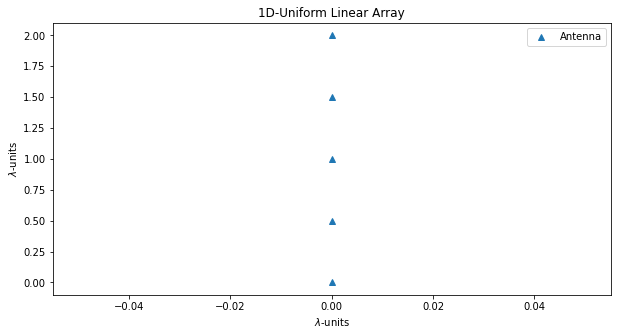

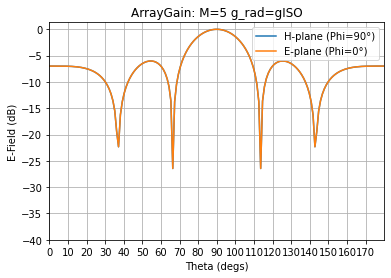

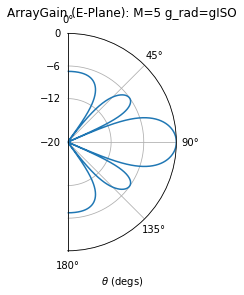

Random Linear Array


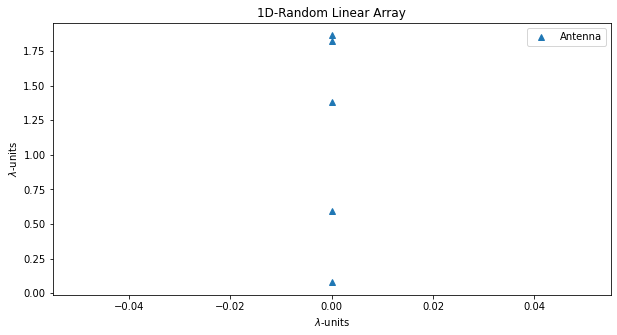

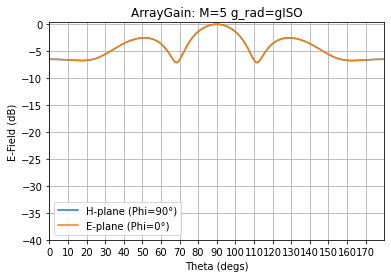

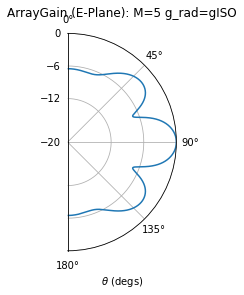

In [5]:
if ULA_flag:
  print('Uniform Linear Array')
  x_sens=[ArrayU.rm[mm][0] for mm in range(ArrayU.M)]
  y_sens=[ArrayU.rm[mm][1] for mm in range(ArrayU.M)]
  z_sens=[ArrayU.rm[mm][2] for mm in range(ArrayU.M)]

  # plt.subplot(221)
  plt.figure(figsize=(10,5))
  plt.plot(x_sens,z_sens,'^')
  plt.title('1D-Uniform Linear Array')
  plt.legend(['Antenna'])
  plt.xlabel(r'$\lambda$-units')                 # Plot formatting
  plt.ylabel(r'$\lambda$-units')                 # Plot formatting

  plt.show()

  ArrayEHPlanePlot(ArrayU, isLog=True)
  # ArrayGainHPlot(ArrayU)
  ArrayGainEPlot(ArrayU)
  # SurfacePlot(ArrayU)

if RLA_flag:
  print('Random Linear Array')
  x_sens=[ArrayR.rm[mm][0] for mm in range(ArrayR.M)]
  y_sens=[ArrayR.rm[mm][1] for mm in range(ArrayR.M)]
  z_sens=[ArrayR.rm[mm][2] for mm in range(ArrayR.M)]

  # plt.subplot(221)
  plt.figure(figsize=(10,5))
  plt.plot(x_sens,z_sens,'^')
  plt.title('1D-Random Linear Array')
  plt.legend(['Antenna'])
  plt.xlabel(r'$\lambda$-units')                 # Plot formatting
  plt.ylabel(r'$\lambda$-units')                 # Plot formatting
  plt.show()

  ArrayEHPlanePlot(ArrayR, isLog=True)
  # ArrayGainHPlot(ArrayR)
  ArrayGainEPlot(ArrayR)
  # SurfacePlot(ArrayR)


    

### Sources (signals) definition

In [6]:
#@title Number of Sources
D =  3#@param {type:"integer"}
random_angles = False #@param {type:"boolean"}
#=============================================================
if random_angles:
  Thetas = 0.5*np.pi*(np.random.rand(D))   # random source directions
  Phis = np.pi*(np.random.rand(D))   # random source directions
  Alphas = np.random.randn(D)#  + np.random.randn(Signal.D)*1j # random source powers
else:
  Thetas=np.array([np.radians(77), np.radians(55), np.radians(15), 
                 np.radians(35), np.radians(67)])
  Thetas = Thetas[:D]
  Phis = np.pi*(np.random.rand(D))   # random source directions
  Alphas = np.ones(D) #  unit-power signals
  
Signal0=Signal(D,Thetas,Phis,Alphas)
print('x_true = ',np.degrees(Thetas[0:Signal0.D]),'\n') # ,xopt21lsq[Signal0.D:].tolist()])
#=============================================================

x_true =  [77. 55. 15.] 



### Array Matrix definition

In [7]:
# A=Matrix(Signal0,Array0) 
# Array Full Matrix
if ULA_flag:
  AU=Matrix2(Signal0.angles,Signal0.amps,rm=ArrayU.rm, g_rad='ISO')
if RLA_flag:
  AR=Matrix2(Signal0.angles,Signal0.amps,rm=ArrayR.rm, g_rad='ISO')

Simulation Parameters

In [8]:
#@title Number of Simulations and SNR interval
Nsims = 200 #@param {type:"integer"}

SNR_ini = -15 #@param {type:"number"}
SNR_end = 15 #@param {type:"number"}

SNR = list(range(SNR_ini,SNR_end)) 
nSNR = len(SNR)

nsim = 0 # First Iter
idx_snr = 15 # 5 dB
snr = SNR[idx_snr]
print('SNR = ',snr, 'dB')

SNR =  0 dB


### Snapshot computation

In [9]:
#@title Number of Snapshots 
N =  200#@param {type:"integer"}

if ULA_flag:
  XU = np.zeros((M,N)) + 1j*np.zeros((M,N))
if RLA_flag:
  XR = np.zeros((M,N)) + 1j*np.zeros((M,N))

sig_n=np.sqrt(0.5/(10**(snr/10)))
for t in range(N):
  s_t = Signal0.amps*np.exp(1j*2*np.pi*np.random.rand(D))
  # s_t=0.5*(np.random.randn(Signal0.D)+1j*np.random.randn(Signal0.D))*Signal0.amps
  # s_t=0.5*np.ones(Signal0.D)
  n_t=sig_n*(np.random.randn(M)+np.random.randn(M)*1j)
  if ULA_flag:
    XU[:,t] = np.matmul(AU.data,s_t)+n_t
  if RLA_flag:
    XR[:,t] = np.matmul(AR.data,s_t)+n_t    

### Autocorrelation Matrix computation

In [10]:
if ULA_flag:
  RXX_U = (1/N)*(XU@XU.conj().transpose())
if RLA_flag:
  RXX_R = (1/N)*(XR@XR.conj().transpose())

## DoA Methods


### Spectrum Based Methods

#### Bartlett

Seguir

In [11]:
def DoA_Bartlett(CovMat,L,Array,Angles):
    # CovMat is the signal covariance matrix, 
    # L is the number of sources, 
    # Array is the structure than describes the array
    #   Array.M is the number of antennas
    #   Array.rm holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    
    numAngles = len(Angles)
    pspectrum = np.zeros(numAngles)
    
    signal_amp = 1 + 1j*0   # Signal amplitude(s) is (are) unknown
    for i in range(numAngles):
        av = ArrayResponse(Array,Angles[i],0)
        con_av = np.conjugate(av.data)
        con_av_tp = con_av.transpose()
        pspectrum[i] = np.abs(con_av_tp @ CovMat @ av.data)

    DoAsBartlett,_= find_peaks(pspectrum,height=1.35, distance=1.5)
    plot_gr = True
    if plot_gr:
      plt.figure(figsize=(10,5))
      plt.plot(np.degrees(Angles),psindB)
      plt.scatter(np.degrees(Angles[DoAsMVDR]),psindB[DoAsMVDR],s=80, marker=(5,2))
      plt.title('DoA estimated by Bartlett')
      plt.legend(['Spectrum'])
      plt.xlabel(r'degrees-units')                 # Plot formatting
      plt.ylabel(r'Angle Power Spectrum')          # Plot formatting
      plt.show()
    return Angles[DoAsMVDR], pspectrum

#### MVDR (Capon)

Capon’s minimum variance distortionless response, or MVDR, evaluates the power of the received signal in all possible directions. The power from the DoA with angle θ is measured by constraining the beamformer gain to be 1 in that direction and using the remaining degrees of freedom to minimize the output power contributions of signals coming from all other directions. The optimization problem can be stated mathematically as a constrained minimization problem. The idea is that for each possible angle θ, the power in the cost function must be minimized.

The disadvantage of this method is that an inverse matrix computation is required which may become poor conditioned if highly correlated signals are present.

In [12]:
def DoA_MVDR(CovMat,L,Array,Angles):
    # CovMat is the signal covariance matrix, 
    # L is the number of sources, 
    # Array is the structure than describes the array
    #   Array.M is the number of antennas
    #   Array.rm holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    
    numAngles = len(Angles)
    # pspectrum = np.zeros(numAngles,dtype=np.complex_)
    pspectrum = np.zeros(numAngles) 
    
    signal_amp = 1 + 1j*0   # Signal amplitude(s) is (are) unknown
    CovMatInv= np.linalg.inv(CovMat)
    for i in range(numAngles):
        av = ArrayResponse(Array,Angles[i],0)
        con_av = np.conjugate(av.data)
        con_av_tp = con_av.transpose()
        
        pspectrum[i] = 1 / np.abs(con_av_tp @ CovMatInv @ av.data)
    psindB = 10*np.log10(pspectrum/pspectrum.min())
    DoAsMVDR,_= find_peaks(pspectrum,height=1.35, distance=1.5)
    plot_gr = True
    if plot_gr:
      plt.figure(figsize=(10,5))
      plt.plot(np.degrees(Angles),psindB)
      plt.scatter(np.degrees(Angles[DoAsMVDR]),psindB[DoAsMVDR],s=80, marker=(5,2))
      plt.title('DoA estimated by MVDR')
      plt.legend(['Spectrum'])
      plt.xlabel(r'degrees-units')                 # Plot formatting
      plt.ylabel(r'Angle Power Spectrum')          # Plot formatting
      plt.show()
    return Angles[DoAsMVDR], pspectrum

### Subspace-based Methods

#### Signal Space Projection
<div>
<img src="https://www.researchgate.net/profile/Laura-Cottatellucci/publication/2561811/figure/fig1/AS:669540857966600@1536642388166/The-projection-onto-the-solution-subspace-spanned-by-the-eigenvectors-with-eigenvalues.png" width="500" alt='DoA'>
</div>


In [13]:
if ULA_flag:
  ES_U=SubProj(RXX_U, L=Signal0.D)
if RLA_flag:
  ES_R=SubProj(RXX_R, L=Signal0.D)

#### Music

MUSIC (MUltiple SIgnal Classification) is an algorithm used for frequency estimation[1] and radio direction finding.[2]




MUSIC algorithm uses intersections between the array manifold and the signal subspace to estimate the directions. 

The steering vectors corresponding to the incoming signals lie in the signal subspace; therefore, they are orthogonal to the noise subspace. One way to estimate the DoAs of multiple signal source is to search through the set
of all possible steering vectors and find those that are orthogonal to the noise subspace. 

In terms of implementation, the MUSIC-DoA first estimates a basis for the noise subspace, Qn, and then determines the L peaks in the Angle Spectrum. The associated angles provide the DoA estimates

<img src="https://es.mathworks.com/help/examples/phased/win64/BeamscanExample_04.png" width="500" alt='DoA Comparison'>
</div>

In [14]:
def MUSIC(CovMat,L,Array,Angles):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    Lamb,V = LA.eig(CovMat)
        
    idx=np.abs(Lamb).argsort()[::-1]
    Lamb=Lamb[idx]
    V=V[:,idx]
    
    L = min(L,Array.M-1)

    Qn  = V[:,L:Array.M]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = ArrayResponse(Array,Angles[i],0)
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    psindB = 10*np.log10(pspectrum/pspectrum.min())
    DoAsMUSIC,_= find_peaks(pspectrum,height=1.35, distance=1.5) # find_peaks(psindB,height=1.35, distance=1.5)
    plot_gr = True
    if plot_gr:
      plt.figure(figsize=(10,5))
      plt.plot(np.degrees(Angles),psindB)
      plt.scatter(np.degrees(Angles[DoAsMUSIC]),psindB[DoAsMUSIC],s=80, marker=(5,2))
      plt.title('DoA estimated by MUSIC')
      plt.legend(['Spectrum'])
      plt.xlabel(r'degrees-units')                 # Plot formatting
      plt.ylabel(r'Angle Power Spectrum')                 # Plot formatting
      plt.show()
      plt.show()
    return Angles[DoAsMUSIC],pspectrum

#### Root-Music

### Parametric Methods

See: 
H. Krim and M. Viberg, "Two decades of array signal processing research: the parametric approach," in IEEE Signal Processing Magazine, vol. 13, no. 4, pp. 67-94, July 1996, [doi: 10.1109/79.526899](https://doi.org/10.1109/79.526899).

fmin1D(x) -> function to be optimized. ||E_S - A(x) T ||^2 



In [15]:
# fmin1D Evaluation
thetas=[]
phis=[]
amps=[]
for d in range(Signal0.D):
    thetas.append(Signal0.angles[d].angle[0])
    phis.append(Signal0.angles[d].angle[1])
    amps.append(Signal0.amps[d])
    
x0=[]
x0.append(thetas)
# x0.append(phis)
# x0.append(amps)

# If T is assumed to be a known parameter, so x_best just contains angles 
# Ideal T matrix
if ULA_flag:
  T_U = np.matmul(LA.pinv(AU.data),ES_U) #  np.eye(Signal.D)
if RLA_flag:
  T_R = np.matmul(LA.pinv(AR.data),ES_R) #  np.eye(Signal.D)    

x_true=[item for sublist in x0 for item in sublist]

# Deterministic ML method
G0=np.eye(M)
Gt0=np.zeros((M,M))
if ULA_flag:
  print('fmin1D(x_true) [ULA] =',format(fmin1D(x_true, Signal0.D, T_U, ES_U, ArrayU, G0,Gt0), "0.6f"))
if RLA_flag:
  print('fmin1D(x_true) [RLA] =',format(fmin1D(x_true, Signal0.D, T_R, ES_R, ArrayR, G0,Gt0), "0.6f"))

#########################
# If T is an unknown parameter, it has to be optimized
if ULA_flag:
  D_T_U=T_U.shape[0]*T_U.shape[0]
  D_T = D_T_U
  T_U_vec=np.zeros(D_T_U*2) # Vector containing real and imaginary elements of T
  T_U_vec=np.concatenate((T_U.real.reshape(D_T_U),T_U.imag.reshape(D_T_U)))
  xT_U_true=np.concatenate((np.array(x_true),T_U_vec))

  print('fmin1D(xT_true) [ULA] =',format(fmin1D(xT_U_true, Signal0.D, ES_U, ArrayU, G0,Gt0), "0.6f"))

if RLA_flag:
  D_T_R=T_R.shape[0]*T_R.shape[0]
  D_T = D_T_R
  T_R_vec=np.zeros(D_T_R*2) # Vector containing real and imaginary elements of T
  T_R_vec=np.concatenate((T_R.real.reshape(D_T_R),T_R.imag.reshape(D_T_R)))
  xT_R_true=np.concatenate((np.array(x_true),T_R_vec))
  print('fmin1D(xT_true) [RLA] =',format(fmin1D(xT_R_true, Signal0.D, ES_R, ArrayR, G0,Gt0), "0.6f"))

fmin1D(x_true) [ULA] = 0.092999
fmin1D(x_true) [RLA] = 0.105596
fmin1D(xT_true) [ULA] = 0.092999
fmin1D(xT_true) [RLA] = 0.105596


The optimization process might require a initial value, x_ini, and some bounds for contrained optimization

Bounds for theta_i:  [[ 0. 90.]
 [ 0. 90.]
 [ 0. 90.]]

Actual DoAs: x_true ->  [77. 55. 15.]


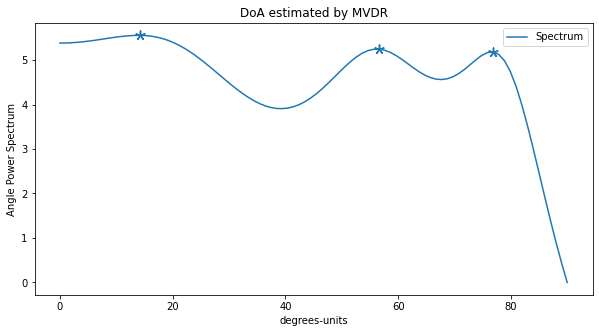


DoAs using MVDR [ULA]:  3 . x_MVDR -> [14.15730337 56.62921348 76.85393258]


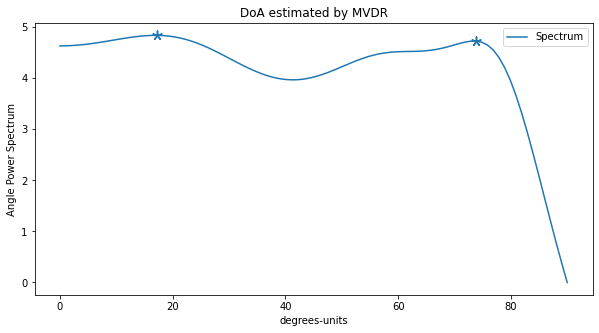


DoAs using MVDR [RLA]:  2 . x_MVDR -> [17.19101124 73.82022472]


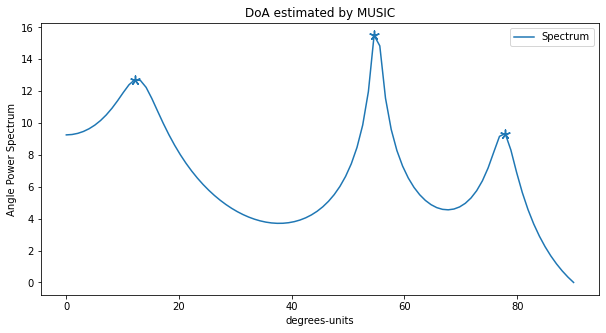


DoAs using MUSIC [ULA]:  3 . x_MUSIC -> [12.13483146 54.60674157 77.86516854]


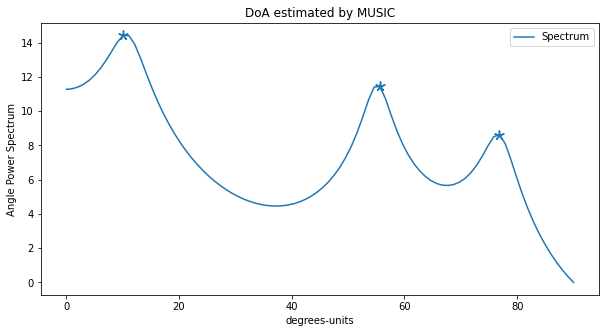


DoAs using MUSIC [RLA]:  3 . x_MUSIC -> [10.11235955 55.61797753 76.85393258]

Initial value [ULA]: x_ini -> [77.86516854 54.60674157 12.13483146]

Initial value [RLA]: x_ini -> [76.85393258 55.61797753 10.11235955]


In [16]:
# Angle Bounds ([Phi_d], d = 0, ... D, [Theta_d], d = 0, ..., D)
# bnds=((0,0.5*np.pi), (0,0.5*np.pi), (0,np.pi), (0,np.pi), (-3,3), (-3,3))
bnds=()
# Bounds for Theta
bnds_theta=(0,0.5*np.pi)
for d in range(Signal0.D):
    bnds += tuple([bnds_theta])

print('Bounds for theta_i: ', np.degrees(bnds))

# Initial Value for DoA optimization
print('\nActual DoAs: x_true -> ', np.degrees(x_true))
# Random initial value wothin the bound limits
xini_theta_U = np.sort(((bnds_theta[1]-bnds_theta[0])*np.random.rand(Signal0.D)+bnds_theta[0])).tolist()
xini_theta_R = np.sort(((bnds_theta[1]-bnds_theta[0])*np.random.rand(Signal0.D)+bnds_theta[0])).tolist()
DoA_angles = np.linspace(bnds_theta[0], bnds_theta[1],90)

# Pre-optimized value using MVDR
if ULA_flag:
  DoAsMVDR_U,_ = DoA_MVDR(RXX_U,Signal0.D,ArrayU,DoA_angles)
  Nangles_MVDR_U = min(len(DoAsMVDR_U), Signal0.D)
  print('\nDoAs using MVDR [ULA]: ',Nangles_MVDR_U,'. x_MVDR ->',np.degrees(DoAsMVDR_U))
if RLA_flag:
  DoAsMVDR_R,_ = DoA_MVDR(RXX_R,Signal0.D,ArrayR,DoA_angles)
  Nangles_MVDR_R = min(len(DoAsMVDR_R), Signal0.D)
  print('\nDoAs using MVDR [RLA]: ',Nangles_MVDR_R,'. x_MVDR ->',np.degrees(DoAsMVDR_R))
# Pre-optimized value using MUSIC
if ULA_flag:
  DoAsMUSIC_U,_ = MUSIC(RXX_U,Signal0.D,ArrayU,DoA_angles)
  Nangles_MUSIC_U = min(len(DoAsMUSIC_U), Signal0.D)
  print('\nDoAs using MUSIC [ULA]: ',Nangles_MUSIC_U,'. x_MUSIC ->',np.degrees(DoAsMUSIC_U))
if RLA_flag:
  DoAsMUSIC_R,_ = MUSIC(RXX_R,Signal0.D,ArrayR,DoA_angles)
  Nangles_MUSIC_R = min(len(DoAsMUSIC_R), Signal0.D)
  print('\nDoAs using MUSIC [RLA]: ',Nangles_MUSIC_R,'. x_MUSIC ->',np.degrees(DoAsMUSIC_R))

ini_MVDR=False # if ini_MVDR = True -> MVDR, else -> MUSIC
if ULA_flag:
  if ini_MVDR:
    Nangles_U = Nangles_MVDR_U
    DoAs_ini_U = DoAsMVDR_U
  else:
    Nangles_U = Nangles_MUSIC_U
    DoAs_ini_U = DoAsMUSIC_U

  for nang in range(Nangles_U):
      xini_theta_U[nang]= DoAs_ini_U[nang]

  xini_theta_U = match_vec(Thetas,np.array(xini_theta_U),lambda x1, x2: abs(x1 - x2))
  print('\nInitial value [ULA]: x_ini ->', np.degrees(xini_theta_U))
if RLA_flag:
  if ini_MVDR:
    Nangles_R = Nangles_MVDR_R
    DoAs_ini_R = DoAsMVDR_R
  else:
    Nangles_R = Nangles_MUSIC_R
    DoAs_ini_R = DoAsMUSIC_R

  for nang in range(Nangles_R):
      xini_theta_R[nang]= DoAs_ini_R[nang]

  xini_theta_R = match_vec(Thetas,np.array(xini_theta_R),lambda x1, x2: abs(x1 - x2))
  print('\nInitial value [RLA]: x_ini ->', np.degrees(xini_theta_R))

Now, we will assume that matrix T is unknown, so it must be "optimized".

Bounds for matrix T

In [17]:
# Bounds for constrained optimization of T
bnds=()
# Bounds for Theta
bnds_theta=(0,0.5*np.pi)
for d in range(Signal0.D):
  bnds += tuple([bnds_theta])
#@title Preinitialization of Matrix T (pinv(A)*E_s)
ini_T = False #@param {type:"boolean"}
if ini_T:
  # xini_alpha = np.random.randn(Signal0.D)#  + np.random.randn(Signal.D)*1j # random source powers
  xini_alpha = np.random.rand(Signal0.D)*np.exp(1j*2*np.pi*np.random.rand(Signal0.D))
  # xini_alpha=np.ones(Signal0.D)
  xini_phi=np.zeros(Signal0.D)
  Signal_ini=Signal(D,xini_theta,xini_phi,xini_alpha)
  # Array Full Matrix
  A_ini=Matrix2(Signal_ini.angles,Signal_ini.amps,rm=Array0.rm, g_rad='ISO')
  T_ini=np.matmul(LA.pinv(A_ini.data),ES) #  np.eye(Signal.D)
  # T is an unknown parameter, so it has to be optimized

  # Bounds for T
  T_max = np.max([np.real(T_ini),np.imag(T_ini)])
  T_min = np.min([np.real(T_ini),np.imag(T_ini)])
  T_factor = 1.2
  bnds_T=(T_factor*T_min, T_factor*T_max)

  xini_T = np.real(T_ini).flatten(order='F').tolist()+np.imag(T_ini).flatten(order='F').tolist()
else:
  bnds_T=(-1,1)
  xini_T=((bnds_T[1]-bnds_T[0])*np.random.rand(2*D_T)+bnds_T[0]).tolist()
  xini_T_U = xini_T
  xini_T_R = xini_T

for d in range(D_T*2):
    bnds += tuple([bnds_T])

bndsa=np.array(bnds).transpose()

#### Optimization Methods


A large class of estimation problems result in a quadratic
programming formulation, and can be efficiently solved
using numerical optimization to compute the estimates. 

These approaches rely on [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

`scipy.optimize.minimize(fun, x0, method=None, bounds=None)`

Minimization of scalar function of one or more variables.

##### [LS Method with bounds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html): 
Solve a nonlinear least-squares problem with bounds on the variables.

`scipy.optimize.least_squares(func, x0, bounds=- inf, inf, method='trf', loss='linear', args=())` [source](https://github.com/scipy/scipy/blob/v1.6.3/scipy/optimize/_lsq/least_squares.py#L240-L950)
> Given the residuals f(x) (an m-D real function of n real variables) and the loss function rho(s) (a scalar function), least_squares finds a local minimum of the cost function F(x):

>> minimize F(x) = 0.5 * sum(rho(f_i(x)**2), i = 0, ..., m - 1)
subject to lb <= x <= ub

In [18]:
# Optimization --------------------------------------------------------

# Simplex Method
Opt_solver_dict = {
    0: 'LS',
    1: 'SLSQP',
    2: 'Powell',
    3: 'L-BFGS-B',
    4: 'COBYLA',
    5: 'GA'
    }

Opt_solver = [0]*3
Opt_solver[0]=Opt_solver_dict[0]
Opt_solver[1]=Opt_solver_dict[1]
Opt_solver[2]=Opt_solver_dict[5]

# LS Method
loss_dict = {
    0: 'linear',
    1: 'soft_l1',
    2: 'cauchy'
    }

loss_method = loss_dict[0]

Opt_Method = {
        0: 'MUSIC 1D',
        1: 'ESPRIT 1D',
        2: 'ML method, '+Opt_solver[0],
        3: 'ML method (Random) '+Opt_solver[0],
        4: 'ML method, '+Opt_solver[2],
        5: 'ML method, T, '+Opt_solver[0],
        6: 'ML method, T (Random) '+Opt_solver[0],
        7: 'ML method, T, '+Opt_solver[2],
        8: 'TLS-ESPRIT, '+Opt_solver[0],
        9: 'TLS-ESPRIT (Random) '+Opt_solver[0],
        10: 'TLS-ESPRIT, '+Opt_solver[2],
        11: 'TLS-ESPRIT, T, '+Opt_solver[0],
        12: 'TLS-ESPRIT, T, (Random) '+Opt_solver[0],
        13: 'TLS-ESPRIT, T, '+Opt_solver[2],
        14: 'ESPAGIT, '+Opt_solver[0],
        15: 'ESPAGIT (Random), '+Opt_solver[0],
        16: 'ESPAGIT, '+Opt_solver[2],
        17: 'ESPAGIT, T, '+Opt_solver[0],
        18: 'ESPAGIT, T (Random) '+Opt_solver[0],
        19: 'ESPAGIT, T, '+Opt_solver[2]
 }

sel_opt_Method = [0, 1, 2 ,3, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18]
 
Opt_Method_list=[]
for key, value in Opt_Method.items():
    temp = [key,value]
    Opt_Method_list.append(temp)

th_est=np.zeros((nSNR, Nsims,len(Opt_Method),Signal0.D))
eth=np.zeros((nSNR, Nsims,len(Opt_Method)))

#### Deterministic Maximum Likelihood (ML)

Minimum error due to Noise (we assume a perfect knowledge of the angle of arrival, and matrix T)

In [19]:
# Selection Matrices

# Deterministic ML method
G0=np.eye(M)
Gt0=np.zeros((M,M))

In [20]:
# ML-Method -------------------------------------------------
# T matrix as (known) input parameter

if ULA_flag:
  args00U=(Signal0.D, T_U, ES_U, ArrayU, G0,Gt0)
  xini00U=np.array(xini_theta_U)

  # LS
  idx = 2

  xopt00lsq=least_squares(fmin1D_lsq, xini00U, args=args00U, bounds=bndsa[:,0:D], loss=loss_method).x
  th_est[idx_snr, nsim,idx,:]=match_vec(Thetas,xopt00lsq,lambda x1, x2: abs(x1 - x2))
  eth[idx_snr, nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

if RLA_flag:
  # Random -----------------------------------------------------
  args00R=(Signal0.D, T_R, ES_R, ArrayR, G0,Gt0)
  xini00R=np.array(xini_theta_R)
  # LS
  idx = 3

  xopt00lsq=least_squares(fmin1D_lsq, xini00R, args=args00R, bounds=bndsa[:,0:D], loss=loss_method).x
  th_est[idx_snr, nsim,idx,:]=match_vec(Thetas,xopt00lsq,lambda x1, x2: abs(x1 - x2))
  eth[idx_snr, nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])



(ML method, LS) x_opt = [77.04991277 55.00846884 14.72614704] . x_true =  [77. 55. 15.]
(ML method, LS) err(x_opt) = 0.2784931748961187

(ML method (Random) LS) x_opt = [76.94214862 54.99984334 14.73573372] . x_true =  [77. 55. 15.]
(ML method (Random) LS) err(x_opt) = 0.2705244451893256


In [21]:
# T is an unknown parameter, so it has to be optimized
if ULA_flag:
  args01U=(Signal0.D, ES_U, ArrayU, G0,Gt0)

  # T matrix included in xini vector
  xini01U=np.concatenate((np.array(xini_theta_U), np.array(xini_T_U)))

  # LS
  idx = 5

  xopt01lsq=least_squares(fmin1D_lsq, xini01U, args=args01U, bounds=bndsa, loss=loss_method).x
  th_est[idx_snr, nsim,idx,:]=match_vec(Thetas,xopt01lsq[0:Signal0.D],lambda x1, x2: abs(x1 - x2))
  eth[idx_snr, nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

if RLA_flag:
  # Random -----------------------------------------------------
  # T is an unknown parameter, so it has to be optimized
  args01R=(Signal0.D, ES_R, ArrayR, G0,Gt0)
  xini01R=np.concatenate((np.array(xini_theta_R), np.array(xini_T_R)))
  # LS
  idx = 6

  xopt01lsq=least_squares(fmin1D_lsq, xini01R, args=args01R, bounds=bndsa, loss=loss_method).x
  th_est[idx_snr, nsim,idx,:]=match_vec(Thetas,xopt01lsq[0:Signal0.D],lambda x1, x2: abs(x1 - x2))
  eth[idx_snr, nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])



(ML method, T, LS) x_opt = [77.48379739 55.04934739 12.66550557] . x_true =  [77. 55. 15.]
(ML method, T, LS) err(x_opt) = 2.3846088385806725

(ML method, T (Random) LS) x_opt = [76.51714904 55.69519402 12.07048697] . x_true =  [77. 55. 15.]
(ML method, T (Random) LS) err(x_opt) = 3.0493419610114154


#### Invariance Methods

##### ESPRIT
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/ESPRIT_2D.gif/350px-ESPRIT_2D.gif" width="500" alt='ESPRIT'>

ESPRIT exploits an underlying rotational invariance among signal subspaces induced by an array of sensors with a translational invariance structure. 


###### ESPRIT - 1D
Only valid for Uniform Linear Arrays

In [22]:
# ESPRIT - 1D algorithm
idx = 1
kappaDelta = ArrayU.k*(ArrayU.rm[1]-ArrayU.rm[0])[2]
xopt_ESPRIT = ESPRIT_1D(RXX_U,Signal0.D,ArrayU.M, kappaDelta)
th_est[idx_snr,nsim,idx,:] = match_vec(Thetas,xopt_ESPRIT[0:Signal0.D],lambda x1, x2: abs(x1 - x2)) 
eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
print('\n\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])



(ESPRIT 1D) x_opt = [77.47607398 55.0519096  12.84506129] . x_true =  [77. 55. 15.]
(ESPRIT 1D) err(x_opt) = 2.207510338811832


###### TLS - ESPRIT

In [23]:
def In(n):
    A = []
    for i in range(n):
        A.append([1 if j == i else 0 for j in range(n)])
    return A
    
# Selection Matrices
# TLS-ESPRIT ---------------------------------------------------
dim = M-1
IN=In(dim)
n_perm=2
G1=np.zeros((n_perm*M,M))
Gt1=np.zeros((n_perm*M,M))

G1[0:dim,0:dim] = np.array(IN) # First Subarray -> Elements 0 to M-1
Iperm = G1[0:M,:]
Gt1[0:M,:] = (Iperm-np.eye(M))

G1[M+1:2*M,1:M] = np.array(IN) # Second Subarray -> Elements 1 to M
Iperm = G1[M:2*M,:]
Gt1[M:2*M,:] = (Iperm-np.eye(M))

In [24]:
# TLS-ESPRIT ---------------------------------------------

if ULA_flag:
  GES_U_ESPRIT=np.matmul(G1,ES_U)

  # T matrix in a (known) input parameter
  args10U=(Signal0.D, T_U, GES_U_ESPRIT, ArrayU, G1,Gt1)
  xini10U=np.array(xini_theta_U)

  # LS
  idx = 8
  xopt10lsq=least_squares(fmin1D_lsq, xini10U, args=args10U, bounds=bndsa[:,0:D], loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt10lsq,lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])
  # T is an unknown parameter, so it has to be optimized
  args11U=(Signal0.D, GES_U_ESPRIT, ArrayU, G1,Gt1)

  # T matrix included in xini vector
  xini11U=np.concatenate((np.array(xini_theta_U), np.array(xini_T_U)))

  # LS
  idx = 11
  xopt11lsq=least_squares(fmin1D_lsq, xini11U, args=args11U, bounds=bndsa, loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt11lsq[0:Signal0.D],lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

if RLA_flag:
  # Random -----------------------------------------------------
  GES_R_ESPRIT=np.matmul(G1,ES_R)
  # T matrix in a (known) input parameter
  args10R=(Signal0.D, T_R, GES_R_ESPRIT, ArrayR, G1,Gt1)
  xini10R=np.array(xini_theta_R)

  # LS
  idx = 9
  xopt10lsq=least_squares(fmin1D_lsq, xini10R, args=args10R, bounds=bndsa[:,0:D], loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt10lsq,lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

  # T is an unknown parameter, so it has to be optimized
  args11R=(Signal0.D, GES_R_ESPRIT, ArrayR, G1,Gt1)

  # T matrix included in xini vector
  xini11R=np.concatenate((np.array(xini_theta_R), np.array(xini_T_R)))

  # LS
  idx = 12
  xopt11lsq=least_squares(fmin1D_lsq, xini11R, args=args11R, bounds=bndsa, loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt11lsq[0:Signal0.D],lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])


(TLS-ESPRIT, LS) x_opt = [77.17696982 55.00486187 14.79992961] . x_true =  [77. 55. 15.]
(TLS-ESPRIT, LS) err(x_opt) = 0.26715186165452837

(TLS-ESPRIT, T, LS) x_opt = [77.55042158 55.05245822 12.50057126] . x_true =  [77. 55. 15.]
(TLS-ESPRIT, T, LS) err(x_opt) = 2.5598554285188886

(TLS-ESPRIT (Random) LS) x_opt = [76.98803175 54.99494219 14.76906361] . x_true =  [77. 55. 15.]
(TLS-ESPRIT (Random) LS) err(x_opt) = 0.23130161878102118

(TLS-ESPRIT, T, (Random) LS) x_opt = [76.45001685 55.61534624 12.09093523] . x_true =  [77. 55. 15.]
(TLS-ESPRIT, T, (Random) LS) err(x_opt) = 3.023870086338587


##### ESPAGIT

In [25]:
# Selection Matrices
# ESPAGIT ------------------------------------------------------
dim=M

I=In(dim)
n_perm=math.factorial(dim)

G=np.empty((n_perm*dim,dim))
Gt=np.empty((n_perm*dim,dim))
nc=0
for Iperm in itertools.permutations(I):
    G[nc*dim:(nc+1)*dim,:]=np.array(Iperm)
    Gt[nc*dim:(nc+1)*dim,:]=(np.array(Iperm)-np.eye(M))
    nc+=1

In [26]:
# ESPAGIT ---------------------------------------------

if ULA_flag:
  GES_U=np.matmul(G,ES_U)
  # T matrix in a (known) input parameter
  args20U=(Signal0.D, T_U, GES_U, ArrayU, G0,Gt)
  xini20U=np.array(xini_theta_U)

  # LS
  idx = 14
  xopt20lsq=least_squares(fmin1D_lsq, xini20U, args=args20U, bounds=bndsa[:,0:D], loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt20lsq,lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])
  
  idx = 2
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])
  # T is an unknown parameter, so it has to be optimized
  args21U=(Signal0.D, GES_U, ArrayU, G0,Gt)
  xini21U=np.concatenate((np.array(xini_theta_U), np.array(xini_T_U)))

  # LS
  idx = 17
  xopt21lsq=least_squares(fmin1D_lsq, xini21U, args=args21U, bounds=bndsa, loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt21lsq[0:Signal0.D],lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])
    
  idx = 5
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

if RLA_flag:
  # Random -----------------------------------------------------
  GES_R=np.matmul(G,ES_R)

  args20R=(Signal0.D, T_R, GES_R, ArrayR, G0,Gt)
  xini20R=np.array(xini_theta_R)
    
  # LS
  idx = 15
  xopt20lsq=least_squares(fmin1D_lsq, xini20R, args=args20R, bounds=bndsa[:,0:D], loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt20lsq,lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

  idx = 3
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])

  # T is an unknown parameter, so it has to be optimized
  args21R=(Signal0.D, GES_R, ArrayR, G0,Gt)
  xini21R=np.concatenate((np.array(xini_theta_R), np.array(xini_T_R)))

  # LS
  idx = 18
  xopt21lsq=least_squares(fmin1D_lsq, xini21R, args=args21R, bounds=bndsa, loss=loss_method).x 

  th_est[idx_snr,nsim,idx,:]=match_vec(Thetas,xopt21lsq[0:Signal0.D],lambda x1, x2: abs(x1 - x2))
  eth[idx_snr,nsim][idx]=np.degrees(LA.norm(Thetas-th_est[idx_snr,nsim,idx,:]))
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])
    
  idx = 6
  print('\n('+Opt_Method[idx]+') x_opt =',np.degrees(th_est[idx_snr,nsim,idx,:]),'. x_true = ', np.degrees(Thetas))
  print('('+Opt_Method[idx]+') err(x_opt) =',eth[idx_snr,nsim][idx])


(ESPAGIT, LS) x_opt = [77.04991277 55.00846884 14.72614704] . x_true =  [77. 55. 15.]
(ESPAGIT, LS) err(x_opt) = 0.27849317620229497

(ML method, LS) x_opt = [77.04991277 55.00846884 14.72614704] . x_true =  [77. 55. 15.]
(ML method, LS) err(x_opt) = 0.2784931748961187

(ESPAGIT, T, LS) x_opt = [77.48379739 55.04934738 12.66550555] . x_true =  [77. 55. 15.]
(ESPAGIT, T, LS) err(x_opt) = 2.3846088636786154

(ML method, T, LS) x_opt = [77.48379739 55.04934739 12.66550557] . x_true =  [77. 55. 15.]
(ML method, T, LS) err(x_opt) = 2.3846088385806725

(ESPAGIT (Random), LS) x_opt = [76.94214862 54.99984334 14.73573371] . x_true =  [77. 55. 15.]
(ESPAGIT (Random), LS) err(x_opt) = 0.270524448011781

(ML method (Random) LS) x_opt = [76.94214862 54.99984334 14.73573372] . x_true =  [77. 55. 15.]
(ML method (Random) LS) err(x_opt) = 0.2705244451893256

(ESPAGIT, T (Random) LS) x_opt = [76.51714904 55.69519401 12.07048698] . x_true =  [77. 55. 15.]
(ESPAGIT, T (Random) LS) err(x_opt) = 3.049341